In [1]:
import numpy as np
from scipy.fft import fft, ifft, fftshift
import tensorflow as tf
!pip install scikit-commpy
import commpy
from datetime import datetime
import matplotlib.pyplot as plt
import pywt
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi as π
from scipy.signal import spectrogram, wavelets
import pywt
import random

# Additional functions
def check_energy(signal, t_span, spectrum):
    energy_signal = np.mean(np.power(np.absolute(signal), 2))
    energy_spectrum = np.mean(np.power(np.absolute(spectrum), 2)) / len(signal)
    if abs(energy_signal - energy_spectrum) > 1e-14:
        print("Error, energy is different: ", abs(energy_signal - energy_spectrum))

    return energy_signal, energy_spectrum


def get_energy(signal, t_span):
    return np.mean(np.power(np.absolute(signal), 2)) * t_span

def Gray_alphabet(bm):
    import numpy as np

    gseq = np.empty((2 ** bm, bm), dtype=int)
    for i in range(2 ** bm):
        buf = i ^ (i >> 1)
        buf = np.asarray([int(x) for x in bin(buf)[2:]])
        gseq[i, :] = np.append(np.zeros(bm - buf.size, dtype=int), buf)
    return gseq


def Gray_QAM_bit_abc(m):
    import numpy as np

    bm = int(m / 2)
    gseq = Gray_alphabet(bm)
    gabc = np.concatenate(
        (np.tile(gseq, reps=(2 ** bm, 1)), np.repeat(gseq, repeats=2 ** bm, axis=0)),
        axis=1,
    )
    return gabc


def Gray_QAM_sym_abc(m, norm=True):
    import numpy as np

    ms = int(np.sqrt(2 ** m))
    abc_side = np.arange(0, ms) * 2 - (ms - 1)
    QAM_abc = np.tile(abc_side, reps=(ms)) + 1j * np.repeat(
        np.flip(abc_side, axis=0), repeats=ms, axis=0
    )
    if norm:
        QAM_abc = QAM_abc / np.std(QAM_abc)
    return QAM_abc


def hard_slice(QAMsyms, m, norm=True):
    import numpy as np
    alphabet = Gray_QAM_sym_abc(m, norm)
    sym_indices = list(map(lambda sym: np.argmin(np.abs(sym - alphabet)), QAMsyms))
    return alphabet[sym_indices], sym_indices


def QAM2gray_bits(QAMsyms, QAM_order, norm=True):
    # Converts vector QAM complex-valued symbols to the Gray coded bits
    # QAMsyms - QAM symbol vector to convert
    # QAM_order - order of the QAM target alphabet (e.g. 16 for 16QAM)
    # norm - whether the targer QAM alphabet has unitary power
    import numpy as np

    m = np.log2(QAM_order)  # Number of bits per QAM symbol

    # Popular error tracking
    if np.mod(m, 1.0) != 0.0:
        raise ValueError("Given QAM order should be some power of 2.")
    if np.mod(m, 2.0) != 0.0:
        raise ValueError(
            "Non-square constellations are not supported (e.g. 32QAM, 128QAM)"
        )
    if QAMsyms.ndim != 1:
        raise ValueError("Input array of QAM symbols must be an array")

    m = int(m)  # Convert bit number to integer after checking its value
    QAM_indices = hard_slice(QAMsyms, m, norm)[
        1
    ]  # Hard slice the input QAM sequence and return its
    bit_alphabet = Gray_QAM_bit_abc(
        m
    )  # Bit patterns, corresponding to every symbol from QAM alphabet
    bit_seq = np.concatenate(
        tuple((bit_alphabet[QAM_ind] for QAM_ind in QAM_indices)), axis=0
    )
    return bit_seq


def QAM_BER_gray(QAMsyms_chk, QAMsyms_ref, QAM_order, norm=True):
    # Calculates BER between the two QAM symbol vectors in input data
    # QAMsyms - QAM symbol vector to convert
    # QAM_order - order of the QAM target alphabet (e.g. 16 for 16QAM)
    # norm - whether the targer QAM alphabet has unitary power
    import numpy as np

    bits_chk = QAM2gray_bits(QAMsyms_chk, QAM_order, norm)
    bits_ref = QAM2gray_bits(QAMsyms_ref, QAM_order, norm)
    BER = np.mean(np.logical_xor(bits_ref, bits_chk))
    return BER


def BER_est(m_order, x, x_ref):
    return QAM_BER_gray(x, x_ref, m_order)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52 kB 722 kB/s 
  Created wheel for scikit-commpy: filename=scikit_commpy-0.7.0-py3-none-any.whl size=58556 sha256=b4cb6bf06b5c126092ca4f0617652880c19e017142dc23b84005d9c5ca6a2dbe
  Stored in directory: /root/.cache/pip/wheels/52/2a/a2/2daff6a2d5e3b96d70fb03e5b0699ce70c98cb4c00c8107c38
Successfully built scikit-commpy


SSFM Tensorflow GPU

In [2]:
def tf_ssfm_manakov_dispersive_step(first, second, dispersion):
    first_new = tf.signal.ifft(tf.signal.fft(first) * dispersion)
    second_new = tf.signal.ifft(tf.signal.fft(second) * dispersion)
    return first_new, second_new


def tf_ssfm_manakov_nonlinear_step(first, second, gamma, delta_z):
    abs_first = tf.cast(tf.math.abs(first), tf.complex128)
    abs_second = tf.cast(tf.math.abs(second), tf.complex128)
    first_new = first * tf.math.exp(
        tf.cast(1.0j * delta_z * 8.0 / 9.0 * gamma, tf.complex128)
        * (abs_first * abs_first + abs_second * abs_second)
    )
    second_new = second * tf.math.exp(
        tf.cast(1.0j * delta_z * 8.0 / 9.0 * gamma, tf.complex128)
        * (abs_first * abs_first + abs_second * abs_second)
    )
    return first_new, second_new


def tf_manakov_fiber_propogate(
    initial_first,
    initial_second,
    t_span,
    fiber_length,
    n_span,
    gamma,
    beta2,
    alpha=0,
    beta3=0,
):

    if abs(fiber_length) < 1e-15:
        return initial_first, initial_second

    dz = fiber_length / n_span

    if len(initial_first) != len(initial_second):
        print(
            "[tf_manakov_fiber_propogate] Error: sizes of first and second polarisation have to be the same!"
        )
        return initial_first, initial_second

    n = len(initial_first)
    w = tf.signal.fftshift(
        np.array(
            [(i - n / 2) * (2.0 * np.pi / t_span) for i in range(n)], dtype=complex
        )
    )
    w2 = tf.math.pow(w, 2)
    w3 = tf.math.pow(w, 3)
 
    dispersion = tf.math.exp(
        (0.5j * beta2 * w2 + 1.0 / 6.0 * beta3 * w3 - alpha / 2.0) * dz
    )
    dispersion_half = tf.math.exp(
        (0.5j * beta2 * w2 + 1.0 / 6.0 * beta3 * w3 - alpha / 2.0) * dz / 2.0
    )
    dispersion_mhalf = tf.math.exp(
        (0.5j * beta2 * w2 + 1.0 / 6.0 * beta3 * w3 - alpha / 2.0) * -dz / 2.0
    )

    # D/2
    first, second = tf_ssfm_manakov_dispersive_step(
        initial_first, initial_second, dispersion_half
    )

    for n in range(n_span):
        first, second = tf_ssfm_manakov_nonlinear_step(first, second, gamma, dz)
        first, second = tf_ssfm_manakov_dispersive_step(first, second, dispersion)
 
    # -D/2
    first, second = tf_ssfm_manakov_dispersive_step(first, second, dispersion_mhalf)

    return first, second


Transmitters blocks

In [3]:
def rrcosfilter_new(nt, beta, t_symb, sample_rate):
    one_over_ts = 1.0 / t_symb
    dt = 1.0 / float(sample_rate)
    t = (np.arange(nt) - nt / 2.0) * dt
    rrc = np.zeros(nt, dtype=float)

    # found ranges for conditions
    zero_pos = np.where(np.isclose(t, 0.0, atol=1e-16, rtol=1e-15))
    if beta != 0:
        nodes_pos = np.where(
            np.isclose(abs(t), 0.25 * t_symb / beta, atol=1e-16, rtol=1e-15)
        )
        all_pos = np.where(
            ~(
                np.isclose(abs(t), 0.25 * t_symb / beta, atol=1e-16, rtol=1e-15)
                | np.isclose(t, 0.0, atol=1e-16, rtol=1e-15)
            )
        )

    else:
        all_pos = np.where(~np.isclose(t, 0.0, atol=1e-16, rtol=1e-15))

    if beta != 0 and np.shape(nodes_pos)[1] != 0:
        nodes_values = (
            np.ones(len(t[nodes_pos]), dtype=float)
            * beta
            * one_over_ts
            / np.sqrt(2)
            * (
                (1.0 + 2.0 / np.pi) * np.sin(0.25 * np.pi / beta)
                + (1.0 - 2.0 / np.pi) * np.cos(0.25 * np.pi / beta)
            )
        )
        rrc[nodes_pos] = nodes_values

    if np.shape(zero_pos)[1] != 0:
        rrc[zero_pos] = one_over_ts * (1.0 + beta * (4.0 / np.pi - 1))

    all_values = (
        np.sin(np.pi * (1.0 - beta) * t[all_pos] * one_over_ts)
        + 4.0
        * beta
        * t[all_pos]
        * one_over_ts
        * np.cos(np.pi * (1.0 + beta) * t[all_pos] * one_over_ts)
    ) / (
        np.pi * t[all_pos] * (1.0 - np.power(4.0 * beta * t[all_pos] * one_over_ts, 2))
    )
    rrc[all_pos] = all_values

    return rrc


def rrcosfilter_our(N, alpha, Ts, Fs):

    return rrcosfilter_new(N, alpha, Ts, Fs) * Ts


def tf_convolution(signal, filter_val):

    np_signal_orig = len(signal)
    # conv_out = tf.zeros((len(signal)), dtype=tf.complex128)
    # conv_out = np.zeros((len(signal)), dtype=complex)
    np_filter = len(filter_val)
    add_zeros = np.array([0.0 for i in range(np_filter)])
    signal_ext = tf.concat((add_zeros, signal, add_zeros), axis=0)
    # print(np.shape(signal), np.shape(signal_ext), np.shape(filter_val))
    np_signal = len(signal_ext)
    # for n in range(np_filter, np_signal + np_filter):
    #     # tf.reduce_sum(filter_val * signal_ext[n - np_filter: n])
    #     # print(np.shape())
    #     conv_out[n - np_filter] = tf.reduce_sum(filter_val * signal_ext[n - np_filter : n])

    conv_out = np.array(
        [
            tf.reduce_sum(filter_val * signal_ext[n - np_filter : n])
            for n in range(np_filter, np_signal_orig + np_filter)
        ]
    )

    conv_out = tf.cast(conv_out, tf.complex128)
    return conv_out


def filter_shaper(signal, filter_val):

    spectrum = tf.signal.fftshift(tf.signal.fft(signal))
    return tf.signal.ifft(tf.signal.ifftshift(spectrum * filter_val))

    # return tf_convolution(signal, filter_val)
    # return np.convolve(signal, filter_val)


def matched_filter(signal, filter_val):
    # return filter_shaper(signal, filter_val) 
        return filter_shaper(signal, filter_val) / tf.cast(
        (tf.reduce_sum(tf.math.abs(filter_val))), tf.complex128
    )
# def matched_filter(signal, filter_val):
#     return filter_shaper(signal, filter_val) 


####### Gray code ##########

# Helper function to xor two characters
def xor_c(a, b):
    return int(0) if (a == b) else int(1)


# Helper function to flip the bit
def flip(c):
    return int(1) if (c == int(0)) else int(0)


# function to convert binary string
# to gray string
def binarytoGray(binary, num_bits_symbol):
    # gray = binary
    gray = np.zeros((len(binary),), dtype=int)
    # MSB of gray code is same as
    # binary code
    NN = int(len(binary) / num_bits_symbol)
    count = 0
    for k in range(0, NN):
        gray[count] = binary[count]
        for j in range(count + 1, count + num_bits_symbol):
            gray[j] = xor_c(binary[j - 1], binary[j])
        count = count + num_bits_symbol
    return gray


# function to convert gray code
# string to binary string
def graytoBinary(gray, num_bits):
    # binary = gray
    NN = int(len(gray) / num_bits)
    binary = np.zeros((len(gray),), dtype=int)
    count = 0
    for k in range(0, NN):
        binary[count] = gray[count]
        for j in range(count + 1, count + num_bits):
            if gray[j] == 0:
                binary[j] = binary[j - 1]
            else:
                binary[j] = flip(binary[j - 1])
        count = count + num_bits
    return binary


# Channel parameters


def get_default_channel_parameters():
    channel = {}
    channel["n_spans"] = 12  # Number of spans
    channel["z_span"] = 80  # Span Length [km]
    channel["alpha_db"] = 0.225  # Attenuation coefficient [dB km^-1]
    channel["alpha"] = channel["alpha_db"] / (10 * np.log10(np.exp(1)))
    channel["gamma"] = 1.2  # Non-linear Coefficient [W^-1 km^-1]. Default = 1.2
    channel["noise_figure_db"] = 4.5  # Noise Figure [dB]. Default = 4.5
    channel["noise_figure"] = 10 ** (channel["noise_figure_db"] / 10)
    channel["gain"] = np.exp(channel["alpha"] * channel["z_span"])  # gain for one span
    channel["dispersion_parameter"] = 16.8  #  [ps nm^-1 km^-1]  dispersion parameter
    channel["beta2"] = (
        -(1550e-9 ** 2) * (channel["dispersion_parameter"] * 1e-3) / (2 * np.pi * 3e8)
    )  # conversion to beta2 - Chromatic Dispersion Coefficient [s^2 km^−1]
    channel["beta3"] = 0
    channel["h_planck"] = 6.6256e-34  # Planck's constant [J/s]
    channel["fc"] = 299792458 / 1550e-9  # carrier frequency
    channel["dz"] = 1.0  # length of the step for SSFM [km]
    channel["nz"] = int(
        channel["z_span"] / channel["dz"]
    )  # number of steps per each span
    channel["noise_density"] = (
        channel["h_planck"]
        * channel["fc"]
        * (channel["gain"] - 1)
        * channel["noise_figure"]
    )

    return channel


def create_channel_parameters(
    n_spans, z_span, alpha_db, gamma, noise_figure_db, dispersion_parameter, dz
):

    alpha = alpha_db / (10 * np.log10(np.exp(1)))
    noise_figure = 10 ** (noise_figure_db / 10)
    gain = np.exp(alpha * z_span)  # gain for one span
    beta2 = (
        -(1550e-9 ** 2) * (dispersion_parameter * 1e-3) / (2 * np.pi * 3e8)
    )  # conversion to beta2 - Chromatic Dispersion Coefficient [s^2 km^−1]
    beta3 = 0
    h_planck = 6.6256e-34  # Planck's constant [J/s]
    # nu = 299792458 / 1550e-9  # light frequency carrier [Hz]
    fc = 299792458 / 1550e-9  # carrier frequency
    nz = int(z_span / dz)  # number of steps per each span
    noise_density = h_planck * fc * (gain - 1) * noise_figure

    channel = {}
    channel["n_spans"] = n_spans  # Number of spans
    channel["z_span"] = z_span  # Span Length [km]
    channel["alpha_db"] = alpha_db  # Attenuation coefficient [dB km^-1]
    channel["alpha"] = alpha
    channel["gamma"] = gamma  # Non-linear Coefficient [W^-1 km^-1]. Default = 1.2
    channel["noise_figure_db"] = noise_figure_db  # Noise Figure [dB]. Default = 4.5
    channel["noise_figure"] = noise_figure
    channel["gain"] = gain  # gain for one span
    channel[
        "dispersion_parameter"
    ] = dispersion_parameter  # [ps nm^-1 km^-1]  dispersion parameter
    channel[
        "beta2"
    ] = beta2  # conversion to beta2 - Chromatic Dispersion Coefficient [s^2 km^−1]
    channel["beta3"] = beta3
    channel["h_planck"] = h_planck  # Planck's constant [J/s]
    channel["fc"] = h_planck  # carrier frequency
    channel["dz"] = dz  # length of the step for SSFM [km]
    channel["nz"] = nz  # number of steps per each span
    channel["noise_density"] = noise_density

    return channel


def create_wdm_parameters(
    n_channels,
    p_ave_dbm,
    n_symbols,
    m_order,
    roll_off,
    upsampling,
    downsampling_rate,
    symb_freq,
    channel_spacing,
    n_polarisations=2,
    np_filter=0,
):
    wdm = {}
    wdm["n_channels"] = n_channels
    wdm["channel_spacing"] = channel_spacing
    wdm["n_polarisations"] = n_polarisations
    wdm["p_ave_dbm"] = p_ave_dbm
    wdm["n_symbols"] = n_symbols
    wdm["m_order"] = m_order
    wdm["roll_off"] = roll_off
    wdm["upsampling"] = upsampling
    wdm["downsampling_rate"] = downsampling_rate
    wdm["symb_freq"] = symb_freq
    wdm["np_filter"] = np_filter
    wdm["p_ave"] = (10 ** (wdm["p_ave_dbm"] / 10)) / 1000

    return wdm


def get_default_wdm_parameters():

    wdm = {}
    wdm["n_channels"] = 1
    wdm["channel_spacing"] = 50
    wdm["n_polarisations"] = 2
    wdm["p_ave_dbm"] = 0
    wdm["n_symbols"] = 2 ** 12
    wdm["m_order"] = 16
    wdm["roll_off"] = 0.1
    wdm["upsampling"] = 8
    wdm["downsampling_rate"] = 1
    wdm["symb_freq"] = 64e9
    wdm["np_filter"] = 2 ** 12
    wdm["p_ave"] = (10 ** (wdm["p_ave_dbm"] / 10)) / 1000

    return wdm


def generate_wdm(wdm, bits_x=None, bits_y=None, points_x=None, points_y=None):

    # n_symbols - Number of Symbols transmitted
    # m_order - Modulation Level
    # roll_off
    # upsampling
    # downsampling_rate

    symb_freq = int(wdm["symb_freq"])  # symbol frequency
    sample_freq = int(
        symb_freq * wdm["upsampling"]
    )  # sampling frequency used for the discrete simulation of analog signals
    dt = 1 / sample_freq
    t_s = 1 / symb_freq  # symbol spacing
    bandwidth = 1 / (2 * t_s)  # Nyquist bandwidth of the base band signal
    ups = int(t_s * sample_freq)  # Number of samples per second in the analog domain
    # np_filter = 2 ** 12  # Filter length in symbols

    start_time = datetime.now()

    #  ######## INITIATE I, Q and noise components of polarization X #########
    p_ave_x_dbm = wdm["p_ave_dbm"]  # dBm
    p_ave_x = (10 ** (p_ave_x_dbm / 10)) / 1000 / 2
    modem_x = commpy.QAMModem(wdm["m_order"])
    n_bits_x = int(modem_x.num_bits_symbol * wdm["n_symbols"])

    if bits_x is None:
        bits_x = np.random.randint(0, 2, n_bits_x, int)  # Random bit stream
    else:
        if len(bits_x) != n_bits_x:
            print(
                "[generate_wdm_old] Error: length of input bits does not correspond to the parameters"
            )

    # bits_x = np.random.randint(0, 2, n_bits_x, int)  # Random bit stream
    gray_x = binarytoGray(bits_x, modem_x.num_bits_symbol)  # after gray code
    if points_x is None:
        points_x = modem_x.modulate(gray_x) / np.sqrt(
            modem_x.Es
        )  # Modulated baud points sQ = mod1.modulate(sB)/np.sqrt(mod1.Es)
        points_x = points_x * np.sqrt(p_ave_x)

    #  ######## INITIATE I, Q and noise components of polarization Y #########
    p_ave_y_dbm = wdm["p_ave_dbm"]  # dBm
    p_ave_y = (10 ** (p_ave_y_dbm / 10)) / 1000 / 2
    modem_y = commpy.QAMModem(wdm["m_order"])
    n_bits_y = int(modem_y.num_bits_symbol * wdm["n_symbols"])

    if bits_y is None:
        bits_y = np.random.randint(0, 2, n_bits_y, int)  # Random bit stream
    else:
        if len(bits_y) != n_bits_y:
            print(
                "[generate_wdm_old] Error: length of input bits does not correspond to the parameters"
            )

    # bits_y = np.random.randint(0, 2, n_bits_y, int)  # Random bit stream
    gray_y = binarytoGray(bits_y, modem_y.num_bits_symbol)  # after gray code
    if points_y is None:
        points_y = modem_y.modulate(gray_y) / np.sqrt(
            modem_y.Es
        )  # Modulated baud points sQ = mod1.modulate(sB)/np.sqrt(mod1.Es)
        points_y = points_y * np.sqrt(p_ave_y)

    #  ######## Turning the Discrete signal in Countinuous  X #########

    points_sequence_x = np.zeros(ups * wdm["n_symbols"], dtype="complex")
    points_sequence_x[
        ::ups
    ] = points_x  # every ups samples, the value of sQ is inserted into the sequence
    points_sequence_x = tf.cast(points_sequence_x, tf.complex128)

    #  ######## Turning the Discrete signal in Countinuous  Y #########

    points_sequence_y = np.zeros(ups * wdm["n_symbols"], dtype="complex")
    points_sequence_y[
        ::ups
    ] = points_y  # every ups samples, the value of sQ is inserted into the sequence
    points_sequence_y = tf.cast(points_sequence_y, tf.complex128)

    #  ######## Root Raised Cosine Filter X #########

    np_sequence = len(points_sequence_x)

    ft_filter_values = tf.signal.fftshift(
        tf.signal.fft(rrcosfilter_our(np_sequence, wdm["roll_off"], t_s, sample_freq))
    )

    ft_filter_values = tf.cast(ft_filter_values, tf.complex128)
    signal_x = filter_shaper(points_sequence_x, ft_filter_values)
    signal_y = filter_shaper(points_sequence_y, ft_filter_values)

    end_time = datetime.now()
    time_diff = end_time - start_time
    execution_time = time_diff.total_seconds() * 1000
    # print("Signal generation took", execution_time, "ms")

    additional = {
        "ft_filter_values": ft_filter_values,
        "bits_y": bits_y,
        "gray_y": gray_y,
        "points_y": points_y,
        "bits_x": bits_x,
        "gray_x": gray_x,
        "points_x": points_x,
        "x_upsampled": points_sequence_x,
        "y_upsampled": points_sequence_y,
    }

    return (
        tf.cast(signal_x, tf.complex128),
        tf.cast(signal_y, tf.complex128),
        additional,
    )


def propagate_manakov(channel, signal_x, signal_y, sample_freq):

    dt = 1 / sample_freq
    nt = len(signal_x)
    # print(nt)
    t_span = dt * nt
    start_time = datetime.now()

    sq_gain = tf.cast(tf.math.sqrt(channel["gain"]), tf.complex128)
    std = tf.cast(tf.math.sqrt(channel["noise_density"] * sample_freq), tf.complex128)
    one_over_sq_2 = tf.cast(1.0 / tf.math.sqrt(2.0), tf.complex128)

    for span_ind in range(channel["n_spans"]):
        signal_x, signal_y = tf_manakov_fiber_propogate(
            signal_x,
            signal_y,
            t_span,
            channel["z_span"],
            channel["nz"],
            channel["gamma"],
            channel["beta2"],
            alpha=channel["alpha"],
            beta3=channel["beta3"],
        )

        noise_x = (
            tf.complex(
                tf.random.normal([nt], 0, 1, dtype=tf.float64),
                tf.random.normal([nt], 0, 1, dtype=tf.float64),
            )
            * one_over_sq_2
        )
        noise_y = (
            tf.complex(
                tf.random.normal([nt], 0, 1, dtype=tf.float64),
                tf.random.normal([nt], 0, 1, dtype=tf.float64),
            )
            * one_over_sq_2
        )

        signal_x = sq_gain * signal_x + noise_x * std
        signal_y = sq_gain * signal_y + noise_y * std

    end_time = datetime.now()
    time_diff = end_time - start_time
    execution_time = time_diff.total_seconds() * 1000
    # print("Signal propagation took", execution_time, "ms")

    return signal_x, signal_y

In [4]:
def receiver(signal_x, signal_y, ft_filter_values, downsampling_rate):

    start_time = datetime.now()
    signal_x = matched_filter(signal_x, ft_filter_values)
    signal_y = matched_filter(signal_y, ft_filter_values)
    sigx_upsampled = np.copy(signal_x)
    signal_x = signal_x[::downsampling_rate]  # downsample
    signal_y = signal_y[::downsampling_rate]

    end_time = datetime.now()
    time_diff = end_time - start_time
    execution_time = time_diff.total_seconds() * 1000
    # print("Matched filter took", execution_time, "ms")

    return signal_x, signal_y, sigx_upsampled


def dispersion_compensation(channel, signal_x, signal_y, dt):

    #  Dispersion compensation #
    nt_cdc = len(signal_x)
    t_span = nt_cdc * dt
    w = tf.signal.fftshift(
        np.array(
            [(i - nt_cdc / 2) * (2.0 * np.pi / t_span) for i in range(nt_cdc)],
            dtype=complex,
        )
    )
    w2 = tf.math.pow(w, 2)
    w3 = tf.math.pow(w, 3)
    dispersion = tf.math.exp(
        (0.5j * channel["beta2"] * w2 + 1.0 / 6.0 * channel["beta3"] * w3)
        * (-channel["z_span"] * channel["n_spans"])
    )
    signal_cdc_x, signal_cdc_y = tf_ssfm_manakov_dispersive_step(
        tf.cast(signal_x, tf.complex128), tf.cast(signal_y, tf.complex128), dispersion
    )

    return signal_cdc_x, signal_cdc_y


def nonlinear_shift(points, points_orig):

    return np.dot(np.transpose(np.conjugate(points_orig)), points_orig) / np.dot(
        np.transpose(np.conjugate(points_orig)), points
    )



In [5]:
def data_for_spectogram(
    channel, wdm, bits_x=None, bits_y=None, points_x=None, points_y=None
):

    sample_freq = int(wdm["symb_freq"] * wdm["upsampling"])  # in our case , it's 2^21
    dt = 1.0 / sample_freq

    signal_x, signal_y, wdm_info = generate_wdm(
        wdm, bits_x=bits_x, bits_y=bits_y, points_x=points_x, points_y=points_y
    )
    points_orig_x = wdm_info["points_x"]
    points_orig_y = wdm_info["points_y"]
    ft_filter_values = wdm_info["ft_filter_values"]
    np_signal = len(signal_x)

    Samples_x_before_fiber = np.copy(wdm_info["x_upsampled"])

    signal_x, signal_y = propagate_manakov(channel, signal_x, signal_y, sample_freq)
    Samples_x_after_fiber = np.copy(signal_x)

    samples_x, samples_y, sigx_upsampled = receiver(
        signal_x, signal_y, ft_filter_values, wdm["downsampling_rate"]
    )
    Samples_x_after_match_filter = np.copy(sigx_upsampled)

    samples_x, samples_y = dispersion_compensation(
        channel, samples_x, samples_y, dt * wdm["downsampling_rate"]
    )
    Samples_x_after_CDC = np.copy(samples_x.numpy())

    sample_step = int(wdm["upsampling"] / wdm["downsampling_rate"])
    points_x = samples_x[::sample_step].numpy()
    points_y = samples_y[::sample_step].numpy()

    nl_shift_x = nonlinear_shift(points_x, points_orig_x)
    points_x_shifted = points_x * nl_shift_x

    nl_shift_y = nonlinear_shift(points_y, points_orig_y)
    points_y_shifted = points_y * nl_shift_y


    Sca = np.sqrt((10 ** (wdm["p_ave_dbm"] / 10) * 1e-3) / 2)
    print("BER (x / y):", BER_est(wdm['m_order'], points_x_shifted/Sca, points_orig_x/Sca), BER_est(wdm['m_order'], points_y_shifted/Sca, points_orig_y/Sca))

    return Samples_x_before_fiber,  Samples_x_after_fiber, Samples_x_after_match_filter, Samples_x_after_CDC , wdm_info

In [6]:
 
QAM = 16
D = 16.8 
NF = 4.5 
gamma = 1.2  
alpha = 0.21  
roll_off = 0.1  
symbol_rate = 32
fiber_length = 10
n_span = 80
Power_DBM = 1
n_symbols=2**15

channel = create_channel_parameters(
    n_spans=n_span,
    z_span=fiber_length,
    alpha_db=alpha,
    gamma=gamma,
    noise_figure_db=NF,
    dispersion_parameter=D,
    dz=1,
)
wdm = create_wdm_parameters(
    p_ave_dbm=Power_DBM,
    n_symbols=n_symbols,
    m_order=QAM,
    roll_off=roll_off,
    upsampling=8,
    downsampling_rate=4,
    symb_freq=symbol_rate * 1e9,
    np_filter=0,
    n_channels=1,
    channel_spacing=0,
)

In [7]:
Samples_x_before_fiber,  Samples_x_after_fiber, Samples_x_after_match_filter, Samples_x_after_CDC_in, wdm_info  = data_for_spectogram(channel, wdm)
Samples_x_after_CDC2 = np.zeros(8 * wdm["n_symbols"], dtype="complex")
Samples_x_after_CDC2[::4] = Samples_x_after_CDC_in
Sca = np.sqrt((10 ** (wdm["p_ave_dbm"] / 10) * 1e-3) / 2)
nl_shift_x = nonlinear_shift(Samples_x_after_CDC2[::8], Samples_x_before_fiber[::8].real/Sca)
Samples_x_after_CDC = Samples_x_after_CDC2 * nl_shift_x 
Samples_x_before_fiber = Samples_x_before_fiber/Sca

BER (x / y): 0.007293701171875 0.007110595703125


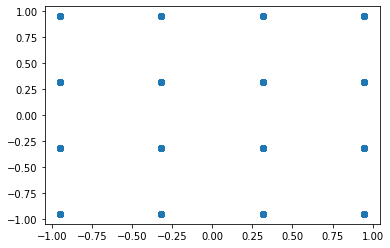

In [8]:
plt.scatter(Samples_x_before_fiber[::8].real,Samples_x_before_fiber[::8].imag)

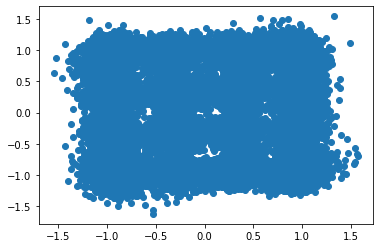

In [9]:
plt.scatter(Samples_x_after_CDC[::8].real,Samples_x_after_CDC[::8].imag)

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# currently (03/2019) scaleogram needs install via https://github.com/alsauve/scaleogram
# because an old PyWavelets (0.5.2) is installend and PyWavelets > 1.0 is needed
!pip install scaleogram
import pywt
import scaleogram as scg 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
!pip install dsatools
import dsatools
from dsatools import utilits as ut
import matplotlib.pyplot as plt
from dsatools._base._imf_decomposition import * 
from sklearn.metrics import mean_squared_error


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 166 kB 2.1 MB/s 


Test The Decomposition Error

/usr/local/lib/python3.7/dist-packages/dsatools/_base/_imf_decomposition/_vmd.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  out[k,:] = (np.fft.ifft(imfs[:,k]))[:N]


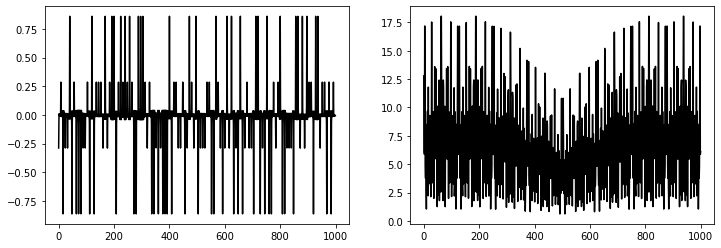

MSE VMD 0.0014970089636942123


/usr/local/lib/python3.7/dist-packages/dsatools/_base/_imf_decomposition/_ewt.py:255: RuntimeWarning: divide by zero encountered in double_scalars
  cof_high = 1./(2*gamma*high)
/usr/local/lib/python3.7/dist-packages/dsatools/_base/_imf_decomposition/_ewt.py:259: RuntimeWarning: divide by zero encountered in double_scalars
  cof_low  = 1./(2*gamma*low)
/usr/local/lib/python3.7/dist-packages/dsatools/_base/_imf_decomposition/_ewt.py:116: ComplexWarning: Casting complex values to real discards the imaginary part
  imfs[i,:] = np.fft.ifft(np.conjugate(filter_)*sp)


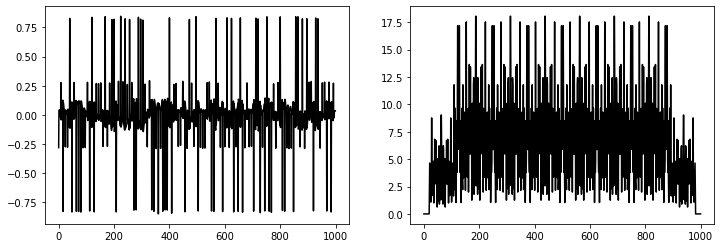

MSE EWT 0.005194062301949519


/usr/local/lib/python3.7/dist-packages/dsatools/_base/_imf_decomposition/_hvd.py:95: ComplexWarning: Casting complex values to real discards the imaginary part
  imf[i,:] = env*np.exp(1j*(2*np.pi*f[i]*n+phase0))


MSE HVD 0.05051295262282189


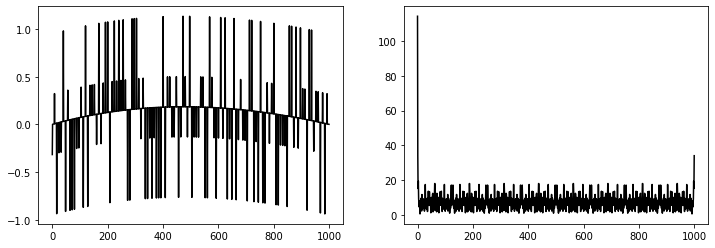

MSE EMD cubic 0.018123888942045054


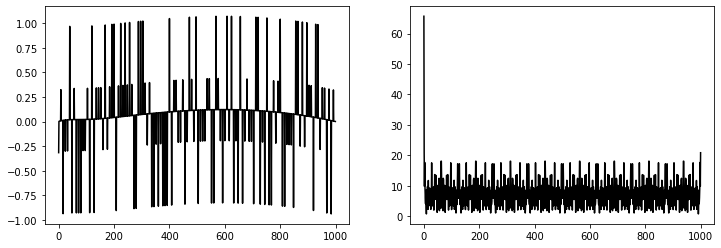

MSE EMD thin 0.006957870101176639


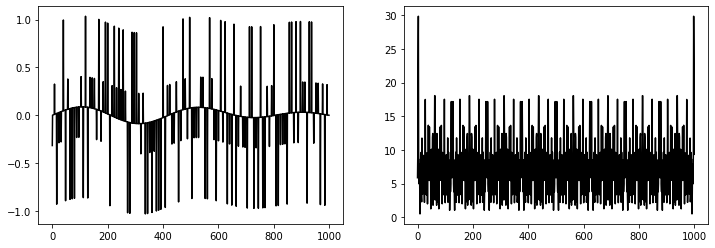

MSE EMD rbf 0.0025543300922778816


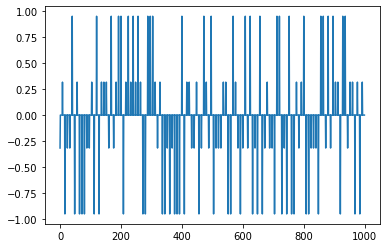

In [12]:
signal1 = np.real(Samples_x_before_fiber[:1000])
# signal1 = Samples_x_before_fiber[:1000]

imfs = vmd(signal1,order=16,reularization=40,)
ut.probe((imfs.sum(axis=0)))
print('MSE VMD', mean_squared_error(signal1, imfs.sum(axis=0)))

imfs = ewt(signal1,order=15, gamma=0., average=100)
ut.probe((imfs.sum(axis=0)))
print('MSE EWT', mean_squared_error(signal1, imfs.sum(axis=0)))

imfs = hvd(signal1, order=16, fpar=100)
ut.probe((imfs.sum(axis=0)));
print('MSE HVD', mean_squared_error(signal1, imfs.sum(axis=0)))

imfs = emd(signal1.real,order=16,method='cubic',max_itter=100, tol = 0.01)
ut.probe((imfs.sum(axis=0))); plt.show()
print('MSE EMD cubic', mean_squared_error(signal1, imfs.sum(axis=0)))

imfs = emd(signal1,order=16,method='thin_plate',max_itter=100, tol = 0.01)
ut.probe((imfs.sum(axis=0))); plt.show()
print('MSE EMD thin', mean_squared_error(signal1, imfs.sum(axis=0)))

imfs = emd(signal1,order=26,method='rbf', max_itter=1000, tol = 0.01)
ut.probe((imfs.sum(axis=0))); plt.show()
print('MSE EMD rbf', mean_squared_error(signal1, imfs.sum(axis=0)))

plt.plot(signal1)


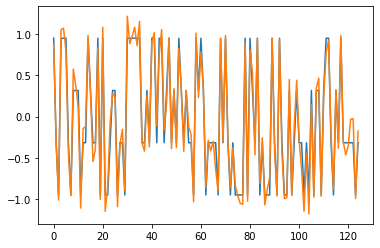

In [26]:
i=3
signal1 = np.real(Samples_x_before_fiber[8000:9000])
signal2 = np.real(Samples_x_after_CDC[8000:9000])
plt.plot(signal1[::8], label='Original')
plt.plot(signal2[::8], label='Receiver')
# plt.legend()
plt.show()

In [14]:
signal1[160:260:8]

array([ 0.9486833 , -0.9486833 , -0.9486833 , -0.31622777,  0.31622777,
        0.31622777, -0.9486833 , -0.31622777, -0.31622777, -0.9486833 ,
        0.9486833 ,  0.9486833 ,  0.9486833 ])

In [15]:
signal2[160:260:8]

array([ 1.08129913, -1.14682923, -0.8496888 , -0.07885345,  0.28102841,
        0.23569454, -1.08989237, -0.34013407, -0.15260952, -0.89717812,
        1.21452532,  0.88150962,  0.97319074])

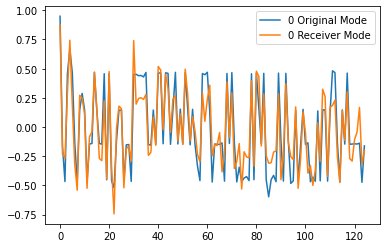

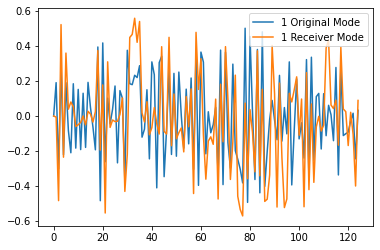

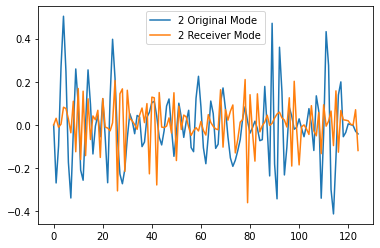

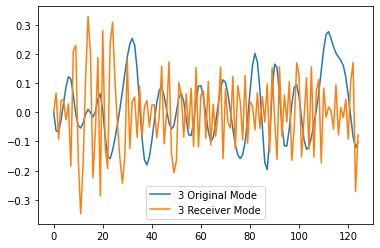

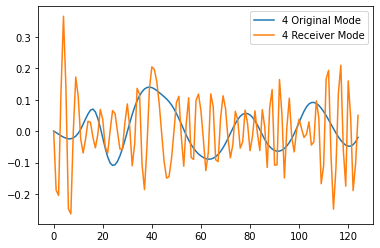

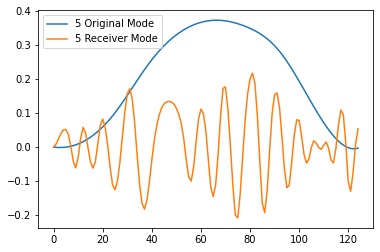

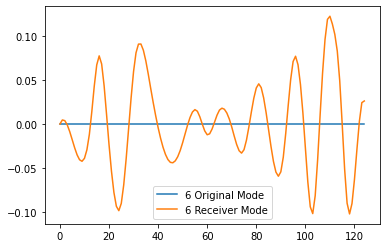

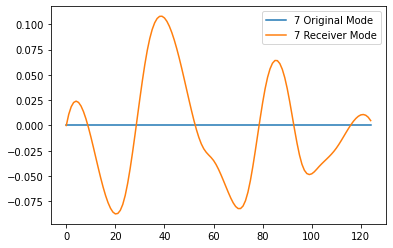

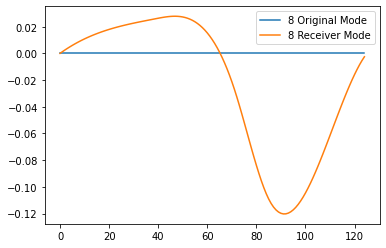

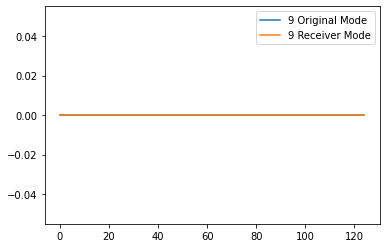

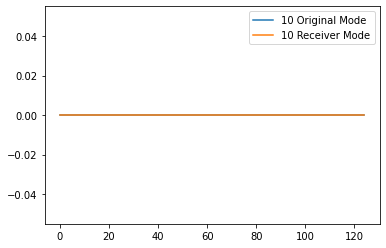

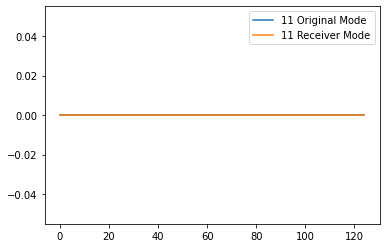

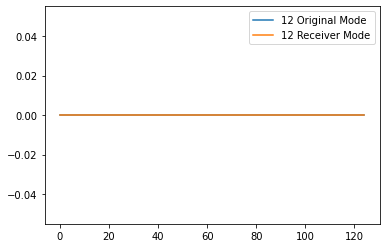

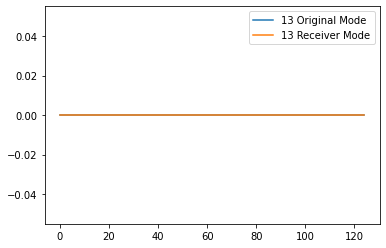

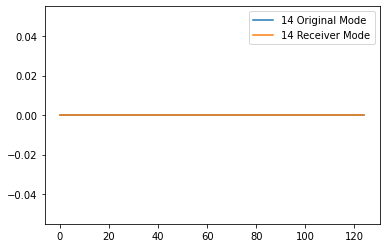

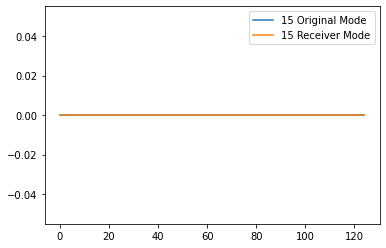

In [16]:
n_orders_decomposition = 16

plt.show()
psds_1 = dsatools.decomposition.emd(signal1,order=n_orders_decomposition, method='cubic',max_itter=100,tol=0.01)
psds_2 = dsatools.decomposition.emd(signal2,order=n_orders_decomposition, method='cubic',max_itter=100,tol=0.0001)
# psds_2 = dsatools.decomposition.emd(signal2,order=n_orders_decomposition, method='cubic')


for i in range(n_orders_decomposition):
  plt.plot(psds_1[i,::8], label='%s Original Mode' % i)
  plt.plot(psds_2[i,::8], label='%s Receiver Mode' % i)
  plt.legend()
  plt.show()

In [17]:
print('MSE original', mean_squared_error(signal2[::8], signal1[::8]))
print('MSE decomposition', mean_squared_error(psds_2.sum(axis=0)[::8], signal1[::8]))
signal_special = psds_2[0] +psds_2[1]+psds_2[2]+psds_2[3]+psds_2[4]+psds_2[5]+psds_2[6]+psds_2[7]+psds_2[8]+psds_2[9]+psds_2[10]+psds_2[11]+psds_2[12] +psds_2[13] +psds_2[14] 
print('MSE decomposition special', mean_squared_error(signal_special[::8], signal1[::8]))


MSE original 0.015621210973672589
MSE decomposition 0.015621210973672592
MSE decomposition special 0.015621210973672592


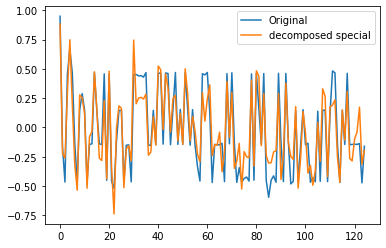

In [18]:
plt.plot(psds_1[0,::8], label='Original')
plt.plot(psds_2[0,::8]+0.005, label='decomposed special')
plt.legend()
plt.show()

**Original Signal** 

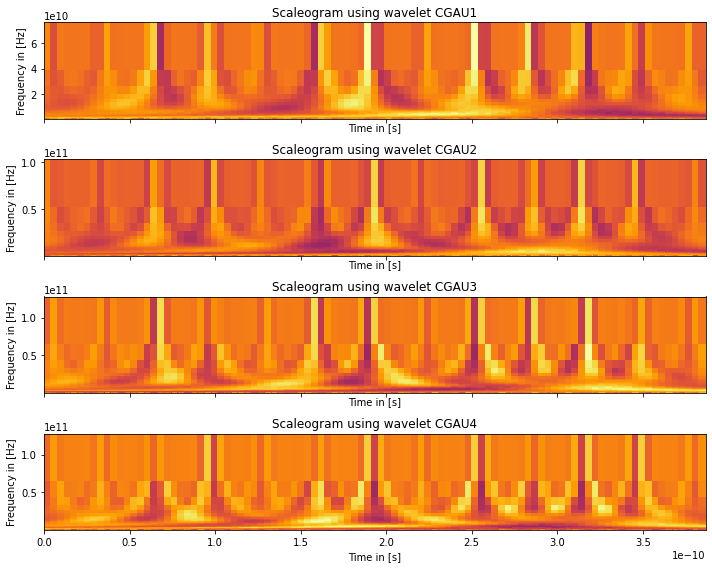

In [27]:
f_s = int(wdm["symb_freq"] * wdm["upsampling"])  # in our case , it's 2^21
dt = 1.0 / f_s
x = Samples_x_before_fiber[:100]
t = np.arange(len(x))*dt
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex = True, figsize = (10,8))

wvoptions=iter(['cgau1','cgau2','cgau3','cgau4'])

axes=[ax1,ax2,ax3,ax4]

# pywt.wavelist(kind='continuous')
# pywt.wavelist(kind='discrete')
for ax in axes:
    # Wavelet transform, i.e. scaleogram
    try:
        choice=next(wvoptions)
        cwtmatr, freqs = pywt.cwt(x, np.arange(1, 512), choice, sampling_period = 1 / f_s)
        im = ax.pcolormesh(t, freqs, cwtmatr.real, vmin=-1.5, cmap = "inferno" )  
        # ax.set_ylim(0,10)
        ax.set_ylabel("Frequency in [Hz]")
        ax.set_xlabel("Time in [s]")
        ax.set_title(f"Scaleogram using wavelet {choice.upper()}")
    except:
        pass
# plt.savefig("./fourplot.pdf")

plt.tight_layout()
plt.show()

**After CDC** 

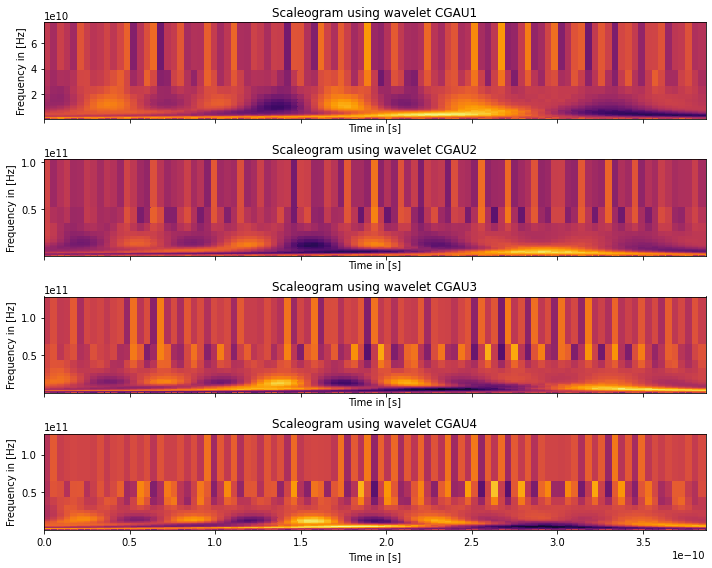

In [28]:
f_s = int(wdm["symb_freq"] * wdm["upsampling"])  # in our case , it's 2^21
dt = 1.0 / f_s
x = Samples_x_after_CDC[:100]
t = np.arange(len(x))*dt
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex = True, figsize = (10,8))

wvoptions=iter(['cgau1','cgau2','cgau3','cgau4'])

axes=[ax1,ax2,ax3,ax4]


for ax in axes:
    # Wavelet transform, i.e. scaleogram
    try:
        choice=next(wvoptions)
        cwtmatr, freqs = pywt.cwt(x, np.arange(1, 512), choice, sampling_period = 1 / f_s)
        im = ax.pcolormesh(t, freqs, cwtmatr.real, vmin=-1.5, cmap = "inferno" )  
        # ax.set_ylim(0,10)
        ax.set_ylabel("Frequency in [Hz]")
        ax.set_xlabel("Time in [s]")
        ax.set_title(f"Scaleogram using wavelet {choice.upper()}")
    except:
        pass
# plt.savefig("./fourplot.pdf")

plt.tight_layout()
plt.show()

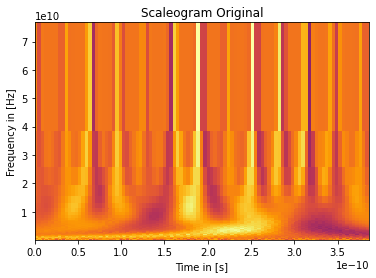

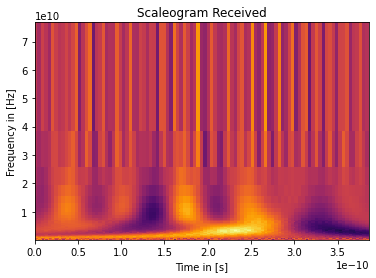

In [21]:
f_s = int(wdm["symb_freq"] * wdm["upsampling"])  # in our case , it's 2^21
dt = 1.0 / f_s
x = Samples_x_before_fiber[:100]
y = Samples_x_after_CDC[:100]
t = np.arange(len(x))*dt
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex = True, figsize = (10,8))
scale = 1000
cwtmatr, freqs = pywt.cwt(x, np.arange(1, scale), 'cgau1', sampling_period = 1 / f_s)
cwtmatry, freqsy = pywt.cwt(y, np.arange(1, scale), 'cgau1', sampling_period = 1 / f_s)
plt.figure()
plt.pcolormesh(t, freqs, cwtmatr.real, vmin=-1.5, cmap = "inferno" )  
plt.ylabel("Frequency in [Hz]")
plt.xlabel("Time in [s]")
plt.title(f"Scaleogram Original")
plt.show()
plt.figure()
plt.pcolormesh(t, freqsy, cwtmatry.real, vmin=-1.5, cmap = "inferno" )  
# ax.set_ylim(0,10)
plt.ylabel("Frequency in [Hz]")
plt.xlabel("Time in [s]")
plt.title(f"Scaleogram Received")
plt.show()

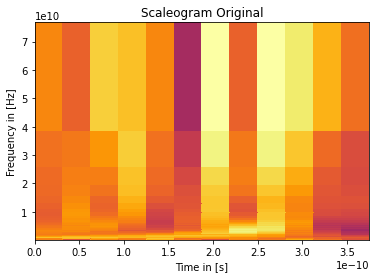

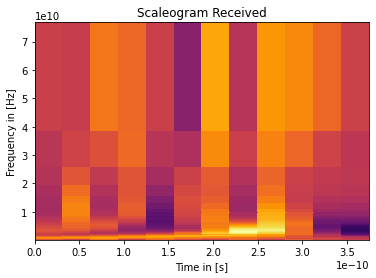

In [29]:
f_s = int(wdm["symb_freq"] * wdm["upsampling"])  # in our case , it's 2^21
dt = 1.0 / f_s
x = Samples_x_before_fiber[:100]
y = Samples_x_after_CDC[:100]
t = np.arange(len(x))*dt
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex = True, figsize = (10,8))
scale = 512
cwtmatr, freqs = pywt.cwt(x, np.arange(1, scale), 'cgau1', sampling_period = 1 / f_s)
cwtmatry, freqsy = pywt.cwt(y, np.arange(1, scale), 'cgau1', sampling_period = 1 / f_s)
plt.figure()
plt.pcolormesh(t[::8], freqs, cwtmatr[:,::8].real, vmin=-1.5, cmap = "inferno" )  
plt.ylabel("Frequency in [Hz]")
plt.xlabel("Time in [s]")
plt.title(f"Scaleogram Original")
plt.show()
plt.figure()
plt.pcolormesh(t[::8], freqsy, cwtmatry[:,::8].real, vmin=-1.5, cmap = "inferno" )  
# ax.set_ylim(0,10)
plt.ylabel("Frequency in [Hz]")
plt.xlabel("Time in [s]")
plt.title(f"Scaleogram Received")
plt.show()

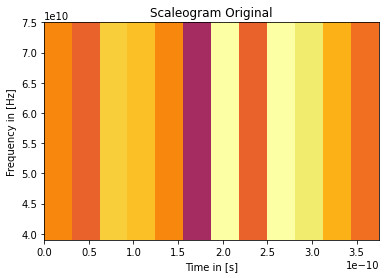

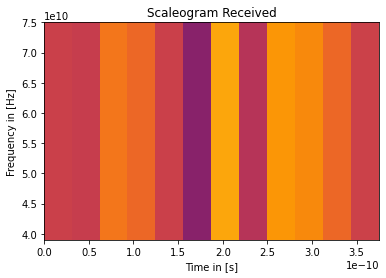

In [30]:
f_s = int(wdm["symb_freq"] * wdm["upsampling"])  # in our case , it's 2^21
dt = 1.0 / f_s
x = Samples_x_before_fiber[:100]
y = Samples_x_after_CDC[:100]
t = np.arange(len(x))*dt
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex = True, figsize = (10,8))
scale = 512
wavelet_type = 'cgau1'
cwtmatr, freqs = pywt.cwt(x, np.arange(1, scale), wavelet_type, sampling_period = 1 / f_s)
cwtmatry, freqsy = pywt.cwt(y, np.arange(1, scale), wavelet_type, sampling_period = 1 / f_s)
plt.figure()
plt.pcolormesh(t[::8], freqs, cwtmatr[:,::8].real, vmin=-1.5, cmap = "inferno" )  
plt.ylim(3.9*10**(10), 7.5*10**(10))
plt.ylabel("Frequency in [Hz]")
plt.xlabel("Time in [s]")
plt.title(f"Scaleogram Original")
plt.show()
plt.figure()
plt.pcolormesh(t[::8], freqsy, cwtmatry[:,::8].real, vmin=-1.5, cmap = "inferno" )  
plt.ylim(3.9*10**(10), 7.5*10**(10))
plt.ylabel("Frequency in [Hz]")
plt.xlabel("Time in [s]")
plt.title(f"Scaleogram Received")
plt.show()

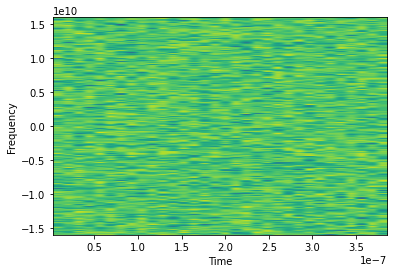

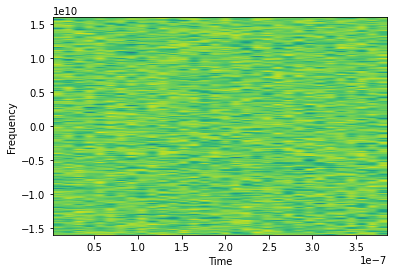

In [24]:
from scipy import signal
x = Samples_x_before_fiber[:100000]
y = Samples_x_after_CDC[:100000]
NFFT=2**9
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(x[::8], NFFT=NFFT, Fs=f_s/8)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(y[::8], NFFT=NFFT, Fs=f_s/8)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()